In [105]:
#import necessary packages
import sys
import os
import numpy as np
import pandas as pd
from utility import load_instances, load_labels, load_timestamps, convert_to_classlabels, write_results

# Load data and extract features

In [106]:
#load data
train_instances = load_instances("data/train")

In [107]:
#define a feature(touch and info) generating function 
def generate_TouchInfo_feature(train_instances):
    X_info =[]
    for i in range(len(train_instances)):
        if list(train_instances[i].info.values())[0] == 'hand':
            X_info.append(1)
        else:
            X_info.append(0)
    X_touch_info = []
    for i in range(len(train_instances)):
        temp = list(train_instances[i].touch.values())
        temp.append(X_info[i])
        X_touch_info.append(temp)
    X_touch_info = pd.DataFrame(X_touch_info)
    X_touch_info.columns = ['x','y','major','minor','pressure','orientation','HoldingStatus'] 
    return X_touch_info

In [108]:
#use FFT to extract acoustic features
from scipy.signal import blackmanharris
from numpy.fft import rfft
from numpy import argmax
from parabolic import parabolic
import matplotlib.pyplot as plt
# from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
#estimate fundamental frequency 
#reference: https://gist.github.com/endolith/255291/71cafad1820118a190a3752388350f1c97acd6de
def parabolic(f, x):
    xv = 1/2 * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - 1/4 * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)
def get_fundamental_frequency(data):
    # Compute Fourier transform of windowed signal
    windowed = data * blackmanharris(len(data))
    f = rfft(windowed)
    # Find the peak and interpolate to get a more accurate peak
    i = argmax(abs(f)) # Just use this for less-accurate, naive version
    true_i = parabolic(abs(f), i)[0]
    sr = 48000
    # Convert to equivalent frequency
    FF = sr * true_i / len(windowed)
    return FF  
def get_ftt(audio_data):
    length = len(audio_data)
    fft_data = fft(audio_data)
    fft_data = fft_data[0:length // 2 + 1]
    #get absulute value for both audio_data and fft_data
    abs_audio_data = np.absolute(audio_data)
    abs_fft_data = np.absolute(fft_data)
    #obatain the fft_data absolute value as feature to avoid complex number feature
    current = np.absolute(fft_data).tolist()
    for j in range(len(fft_data) // 8):
        current.append(np.absolute(sum(fft_data[j * 8: (j + 1) * 8])))
    mean_audio = np.mean(abs_audio_data)
    total_audio = sum(abs_audio_data)
    std_audio = np.std(abs_audio_data)
    center_mass_audio = np.mean(audio_data)
    mean_fft = np.mean(abs_fft_data)
    total_fft = sum(abs_fft_data)
    std_fft = np.std(abs_fft_data)
    center_mass_fft = np.mean(fft_data)
    FF = get_fundamental_frequency(audio_data)
    current.append(mean_audio)
    current.append(total_audio)
    current.append(std_audio)
    current.append(center_mass_audio)
    current.append(mean_fft)
    current.append(total_fft)
    current.append(std_fft)
    current.append(np.absolute(center_mass_fft))
    current.append(FF)
    return current

In [109]:
#define a feature(Audio) generating function
def generate_Audio_feature(train_instances):
    X_audio = []
    for i in range(len(train_instances)):
        wav = train_instances[i].audio
        X_audio.append(get_ftt(wav))
    return pd.DataFrame(X_audio)

In [110]:
#generating training features
X_touch_info = generate_TouchInfo_feature(train_instances)
X_audio = generate_Audio_feature(train_instances)

In [111]:
X_touch_info.to_csv("X_touch_info.csv",index=False)
X_audio.to_csv("X_audio.csv",index=False)

# EDA(Exploratory Data Analysis)

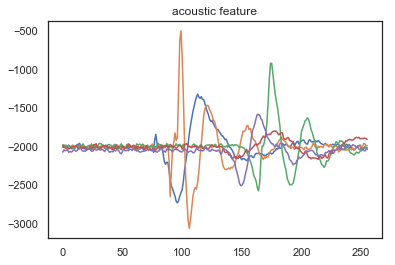

In [112]:
# Visualize the acoustics features
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(0,25000,5000):
    data = train_instances[i].audio
    plt.plot(data)
    plt.title('acoustic feature')

In [113]:
#touch and info dataset statistics summary
X_touch_info.describe()

,x,y,major,minor,pressure,orientation,HoldingStatus
count,20659.000000,20659.000000,20659.000000,20659.000000,20659.0,20659.0,20659.000000
mean,541.317440,940.129145,4.578586,4.223099,0.0,-1.0,0.420737
std,289.368943,502.680342,1.013873,1.006628,0.0,0.0,0.493689
min,0.000000,0.000000,2.000000,2.000000,0.0,-1.0,0.000000
25%,290.000000,497.000000,4.000000,4.000000,0.0,-1.0,0.000000
50%,542.000000,938.000000,4.000000,4.000000,0.0,-1.0,0.000000
75%,791.500000,1379.000000,5.000000,5.000000,0.0,-1.0,1.000000
max,1079.000000,1919.000000,11.000000,10.000000,0.0,-1.0,1.000000


### As there is only one single value for pressure and orientation, so I drop these two features.

In [114]:
#drop unusefel features
X_touch_info = X_touch_info.ix[:,[0,1,2,3,6]]

In [115]:
#load train labels
y_train = load_labels(train_instances)

### Here we only pick 500 instances to explore the touch and surface type features

In [116]:
X_scatter = X_touch_info[:500]
Y_scatter = pd.DataFrame(y_train[:500])
Data = pd.concat( [X_scatter, Y_scatter], axis=1)
Data.columns = ['x', 'y', 'major', 'minor', 'surface type', 'label']

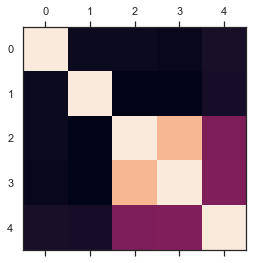

In [117]:
#heatmap
plt.matshow(X_touch_info.corr());

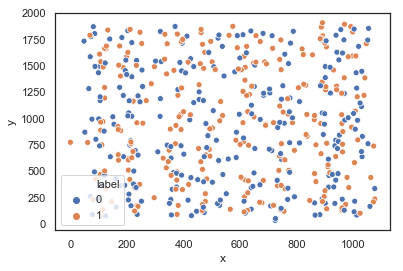

In [118]:
#Data.plot.scatter
%matplotlib inline
import seaborn as sns
sns.scatterplot(x="x", y="y", hue="label",data=Data);

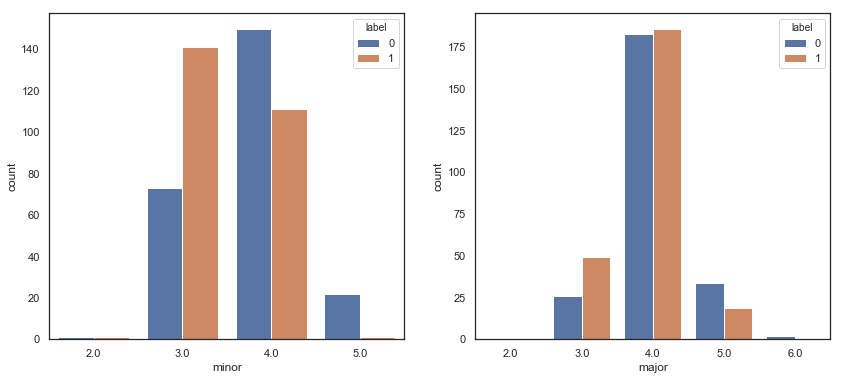

In [119]:
#histogram
import matplotlib.pyplot as plt
fig, (ax1, ax2)= plt.subplots(nrows=1, ncols=2, figsize=(14,6))
sns.countplot(x="minor", hue="label", data=Data, ax=ax1)
sns.countplot(x="major", hue="label", data=Data, ax=ax2);

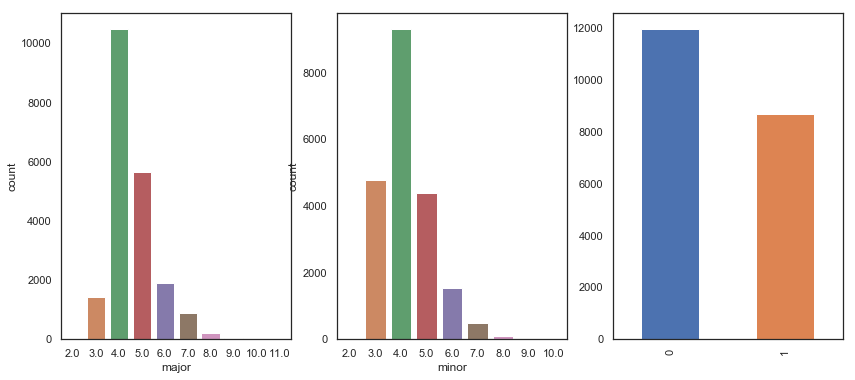

In [120]:
#explore the distribution of 'major', 'minor', 'surface type'
fig, (ax1, ax2, ax3)= plt.subplots(nrows=1, ncols=3, figsize=(14,6))
sns.countplot(x=X_touch_info['major'], data=X_touch_info, ax=ax1)
sns.countplot(x=X_touch_info['minor'], data=X_touch_info, ax=ax2)
X_touch_info['HoldingStatus'].value_counts().plot(kind='bar', ax = ax3);

In [121]:
X_audio.describe()

,0,1,2,3,4,5,6,7,8,9,...,144,145,146,147,148,149,150,151,152,153
count,20659.000000,20659.000000,20659.000000,20659.000000,20659.000000,20659.000000,20659.000000,20659.000000,20659.000000,20659.000000,...,20659.000000,20659.000000,2.065900e+04,20659.000000,20659.000000,20659.000000,2.065900e+04,20659.000000,20659.000000,20659.000000
mean,433345.248124,47742.477026,41114.041044,39547.570234,37516.024905,37153.713806,37215.167505,36669.395980,36054.068059,35977.681403,...,1441.909406,1890.875946,4.840642e+05,827.966454,-1666.101695,11393.172611,1.469719e+06,42239.416425,3551.295569,204.281192
std,126602.025038,58832.709962,44286.693280,42138.386857,43258.628892,43625.263633,44933.210002,44410.341889,43179.047267,42757.132075,...,2004.287490,497.071869,1.272504e+05,843.908824,578.011699,9209.667994,1.188047e+06,10826.090663,856.137534,685.384121
min,200.000000,16.027563,43.009133,54.184439,15.694858,7.193537,18.150838,7.422334,40.425240,7.421278,...,2.464306,115.515625,2.957200e+04,13.964710,-2501.847656,935.701778,1.207055e+05,2696.368561,55.589670,8.458406
25%,379060.500000,6405.123997,10147.148935,11322.873115,9533.872672,8852.188665,7861.392363,6924.706882,6011.856264,5230.698625,...,435.639079,1680.193359,4.301295e+05,274.830722,-2007.285156,5071.703639,6.542498e+05,37465.436642,3341.028095,46.918868
50%,505527.000000,26590.915055,24854.338840,25164.202199,22053.807161,20878.285507,20721.178836,20776.771979,20716.192247,20712.873571,...,843.709171,2000.347656,5.120890e+05,533.606624,-1974.714844,7758.001668,1.000782e+06,44944.882877,3932.722444,48.775549
75%,513865.000000,66900.623213,56246.694695,53113.131194,48690.359674,48054.340975,48367.529164,48647.939922,50030.617471,51612.313354,...,1739.611287,2100.300781,5.376770e+05,1087.626852,-1480.705078,14638.307260,1.888342e+06,46704.629645,3993.681488,53.430796
max,640473.000000,484851.223568,350960.487635,401062.416103,383961.947944,365313.512170,437053.462017,410009.561868,423955.484497,479161.454084,...,75723.909659,4693.335938,1.201494e+06,7020.831271,1480.039062,77000.672083,9.933087e+06,113284.243274,20768.156880,9143.702874


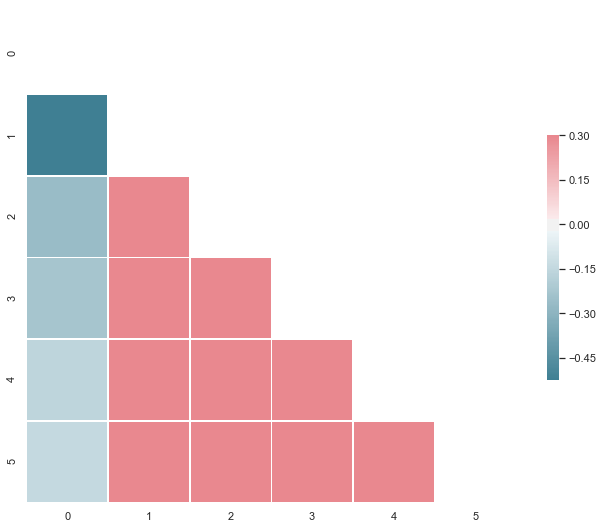

In [122]:
%matplotlib inline
#Heatmap reference: https://stackoverflow.com/questions/36560829/seaborn-heatmap-with-frames
from string import ascii_letters
sns.set(style="white")
# Compute the correlation matrix
corr = X_audio[[0,1,2,3,4,5]].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

### To do more data exploration easier, make computation faster, and reduce some potential noise, I applied PCA to reduce the audio features from 154 to 35 which still explaines 0.95 variance of the original features

In [123]:
# Apply scaling for PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_audio)
from sklearn.decomposition import PCA
pca = PCA(n_components=35).fit(X_scaled)
X_pca = pca.transform(X_scaled)

print(sum(pca.explained_variance_ratio_)) 
X_pca = pd.DataFrame(X_pca)

0.9502548778915955


In [124]:
X_pca.describe()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
count,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,...,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04,2.065900e+04
mean,1.184009e-15,8.635008e-17,-3.569062e-16,8.406289e-16,-5.110175e-17,-3.161226e-16,4.686163e-17,-7.072237e-17,1.608880e-16,1.095928e-16,...,-4.836636e-19,-3.293749e-17,-4.578682e-17,1.804603e-17,1.919876e-17,-1.203946e-16,-1.715864e-17,-2.503765e-17,-5.734101e-18,-1.471681e-17
std,9.678949e+00,3.381864e+00,2.692886e+00,2.513467e+00,2.286257e+00,1.956560e+00,1.692450e+00,1.626054e+00,1.331110e+00,1.112790e+00,...,4.770878e-01,4.646063e-01,4.501104e-01,4.468413e-01,4.305677e-01,4.229558e-01,4.206012e-01,4.038103e-01,3.976320e-01,3.942723e-01
min,-6.839434e+00,-1.617561e+01,-3.960325e+01,-1.384627e+01,-4.174743e+01,-3.466321e+01,-2.776967e+01,-1.595225e+01,-1.431542e+01,-1.532874e+01,...,-7.510384e+00,-8.434292e+00,-9.763022e+00,-1.042987e+01,-9.514317e+00,-7.428947e+00,-1.048767e+01,-9.782882e+00,-7.094104e+00,-6.786403e+00
25%,-5.430896e+00,-1.303604e+00,-1.215631e+00,-1.373523e+00,-6.672758e-01,-5.494513e-01,-2.769056e-01,-5.095622e-01,-3.730156e-01,-2.212367e-01,...,-1.217827e-01,-1.053693e-01,-1.197695e-01,-1.065424e-01,-1.086774e-01,-1.248186e-01,-9.490254e-02,-9.592480e-02,-1.018215e-01,-1.074934e-01
50%,-3.459087e+00,9.042339e-01,-3.914600e-01,-9.196592e-01,-1.499287e-01,-2.141691e-02,-4.897779e-02,9.856600e-02,-7.644612e-02,-3.093435e-02,...,5.771204e-03,-4.004971e-03,-2.089374e-03,-5.696053e-03,3.835641e-04,-1.372982e-02,3.928142e-03,1.341432e-03,6.746672e-03,6.631365e-03
75%,1.624818e+00,1.488258e+00,9.865971e-01,9.686615e-01,3.700081e-01,3.174647e-01,3.416781e-01,4.425589e-01,4.044145e-01,2.923088e-01,...,1.217195e-01,1.035739e-01,1.170143e-01,9.944270e-02,1.050191e-01,1.119543e-01,9.993318e-02,9.752397e-02,1.076530e-01,1.001665e-01
max,1.511214e+02,7.725527e+01,4.653690e+01,1.836111e+01,6.121923e+01,3.637345e+01,3.263326e+01,2.873353e+01,1.679271e+01,4.083483e+01,...,8.762509e+00,1.560039e+01,1.676230e+01,1.134671e+01,1.068538e+01,9.132529e+00,2.583603e+01,1.271024e+01,1.337998e+01,8.485157e+00


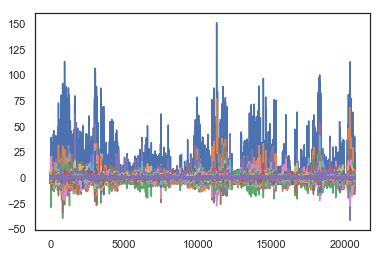

In [125]:
plt.plot(X_pca, '-', );

In [126]:
X_train = pd.concat( [X_touch_info, X_audio], axis=1)
X_train.columns = [i for i in range(159)]

In [127]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
0,913.0,349.0,4.0,4.0,0,512616.0,3648.319970,9118.162851,17781.580715,17241.432110,...,251.714709,2002.406250,512616,209.418295,-2002.406250,5148.630563,6.641733e+05,44962.745513,3981.334376,46.944473
1,366.0,1455.0,4.0,4.0,0,515115.0,2210.170850,4420.751969,10512.184379,12305.313272,...,173.442014,2028.839844,519383,554.273315,-2012.167969,9831.651354,1.268283e+06,45336.700866,3990.451951,49.041705
2,611.0,425.0,4.0,4.0,0,520141.0,22197.127559,12515.242784,16124.333261,5830.027992,...,709.065674,2119.238281,542525,593.767383,-2031.800781,11080.046829,1.429326e+06,46435.432866,4033.360012,49.355431
3,713.0,1783.0,5.0,5.0,0,513481.0,5504.018917,9921.437532,19047.501202,33814.558252,...,350.019915,2077.027344,531719,626.894244,-2005.785156,9833.263482,1.268491e+06,46053.409239,4004.957447,48.281345
4,370.0,1871.0,5.0,4.0,0,512416.0,6216.236745,6694.424851,17738.801774,30484.816954,...,830.377491,2041.031250,522504,532.554456,-2001.625000,8739.589423,1.127407e+06,45514.346660,3984.579066,48.801287


In [128]:
#labels ratio
ratio = round(sum(y_train)/len(y_train),4)
print('the percentage of knuckle in the label is :', ratio)

the percentage of knuckle in the label is : 0.4964


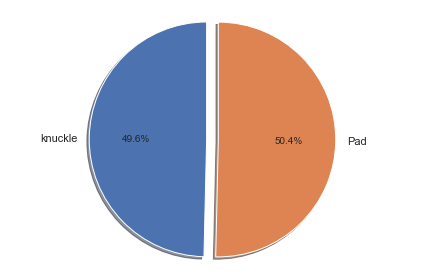

In [129]:
# 2 labels distribution
# fancy pie plot
%matplotlib inline
import matplotlib.pyplot as plt
# Pie chart
labels = ['knuckle', 'Pad']
sizes = [sum(y_train), len(y_train) - sum(y_train)]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1)  
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Machine Learning Model

In [130]:
#Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
rf = RandomForestClassifier(n_estimators = 50, max_features='auto', criterion = 'entropy', oob_score = True)
rf.fit(X_train, y_train)

print('out of bag score')
print(rf.oob_score_)

out of bag score
0.9491746938380367


In [124]:
#gridsearch for random forest
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [10, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rf = RandomForestClassifier()
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
print("Best score: %0.3f" % CV_rfc.best_score_)
print("Best parameters set:")
best_parameters = CV_rfc.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.939
Best parameters set:
	criterion: 'entropy'
	max_depth: 8
	max_features: 'auto'
	n_estimators: 50


## data split and scale

In [131]:
X_train_R.shape

(16527, 159)

In [132]:
#split data into training group and testing group
from sklearn.model_selection import train_test_split
y = y_train
X = X_train
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=56, shuffle = True)

In [133]:
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Flatten Data
from sklearn.preprocessing import StandardScaler, RobustScaler
rob_scaler = RobustScaler()
# Use robust scaler to reduce outliers
X_train_R = rob_scaler.fit_transform(X_train)
X_test_R = rob_scaler.transform(X_test)
X_R = rob_scaler.transform(X)

In [134]:
#SVM model
from sklearn.svm import SVC
svm_clf = SVC(kernel = 'rbf', C = 10, gamma = 0.01)
svm_clf.fit(X_train_R, y_train)
svm_predictions = svm_clf.predict(X_test_R) # Save prediction

#print(svm_clf.score(X_test_R, y_test))
scores = cross_val_score(svm_clf, X_train_R, y_train, cv=5)

print("cross validation score")
print(scores)
print("cross validation accuracy: %0.4f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
print("AUC Score (Test): %f" % roc_auc_score(y_test, svm_predictions))
print("Testset report")
print(mt.classification_report(y_test, svm_predictions))
print("Testset confusion matrix")
print(mt.confusion_matrix(y_test, svm_predictions))
print("Testset accuracy")
print(round(accuracy_score(svm_predictions, y_test),6))

cross validation score
[0.95251059 0.95190563 0.94765507 0.94856278 0.94916793]
cross validation accuracy: 0.9500 (+/- 0.00)

AUC Score (Test): 0.952348
Testset report
             precision    recall  f1-score   support

          0       0.96      0.95      0.95      2112
          1       0.95      0.95      0.95      2020

avg / total       0.95      0.95      0.95      4132

Testset confusion matrix
[[2009  103]
 [  94 1926]]
Testset accuracy
0.952323


In [120]:
#find the best parameters for SVM
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

parameters = {
              'C': [0.001, 0.01, 0.1, 1, 10],
              'gamma': [0.001, 0.01, 0.1, 1, 10],
              'kernel': ['rbf','poly','linear']
}

svm_clf = SVC()
#grid search 
gsearch = GridSearchCV(svm_clf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(X_train_R, y_train)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.948
Best parameters set:
	C: 10
	gamma: 0.01
	kernel: 'rbf'


In [160]:
#xgboost model
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

xgb_clf = XGBClassifier(booster = 'gbtree', learning_rate = 0.3, max_depth = 6)
xgb_clf.fit(X_train_R, y_train)

xgb_predictions = xgb_clf.predict(X_test_R)

scores = cross_val_score(xgb_clf, X_train_R, y_train, cv=5)

print("cross validation score")
print(scores)
print("cross validation accuracy: %0.4f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))
print("AUC Score (Test): %f" % roc_auc_score(y_test, xgb_predictions))
print("Testset report")
print(mt.classification_report(y_test, xgb_predictions))
print("Testset confusion matrix")
print(mt.confusion_matrix(y_test, xgb_predictions))
print("Testset accuracy")
print(round(accuracy_score(xgb_predictions, y_test),6))

cross validation score
[0.96249244 0.9646098  0.96187595 0.96187595 0.96248109]
cross validation accuracy: 0.9627 (+/- 0.00)

AUC Score (Test): 0.969975
Testset report
             precision    recall  f1-score   support

          0       0.97      0.97      0.97      2112
          1       0.97      0.97      0.97      2020

avg / total       0.97      0.97      0.97      4132

Testset confusion matrix
[[2050   62]
 [  62 1958]]
Testset accuracy
0.96999


In [161]:
#xgboost model, using stratified cross validation
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

xgb_clf = XGBClassifier(booster = 'gbtree', learning_rate = 0.3, max_depth = 6)
xgb_clf.fit(X_train_R, y_train)

xgb_predictions = xgb_clf.predict(X_test_R)
strKFold = StratifiedKFold(n_splits=5,shuffle=False,random_state=0)
scores = cross_val_score(xgb_clf,X_train_R,y_train,cv=strKFold)
print("straitified cross validation scores:{}".format(scores))
print("Mean score of straitified cross validation:{:.4f}".format(scores.mean()))

straitified cross validation scores:[0.96249244 0.9646098  0.96187595 0.96187595 0.96248109]
Mean score of straitified cross validation:0.9627


In [98]:
#find the best parameters for xgboost
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')
parameters = {
              'max_depth': [3, 6, 10],
              'learning_rate': [0.1, 0.3, 0.5],
              'booster': ['gbtree', 'gblinear' , 'dart']
}

xlf = xgb.XGBClassifier()
#grid search 
gsearch = GridSearchCV(xlf, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(X_R, y)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.940
Best parameters set:
	booster: 'gbtree'
	learning_rate: 0.5
	max_depth: 10


In [159]:
#evaluate the xgboost model
from xgboost import XGBClassifier
os.environ['KMP_DUPLICATE_LIB_OK']='True'

xgb_clf = XGBClassifier(booster = 'gbtree', learning_rate = 0.3, max_depth = 6)
xgb_clf.fit(X_R, y)

strKFold = StratifiedKFold(n_splits=30,shuffle=False,random_state=0)
scores = cross_val_score(xgb_clf, X_R, y, cv = strKFold)

print("cross validation score")
print(scores)
print("cross validation accuracy: %0.4f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

cross validation score
[0.87082729 0.97677794 0.99419448 0.92162554 0.88243832 0.94629898
 0.93033382 0.95645864 0.97387518 0.99709724 0.99274311 0.98548621
 0.97822932 0.99274311 0.9245283  0.97532656 0.98693759 0.97822932
 0.95500726 0.94629898 0.93904209 0.93323657 0.90566038 0.89114659
 0.93313953 0.96215429 0.92285298 0.98981077 0.99126638 0.91848617]
cross validation accuracy: 0.9517 (+/- 0.07)



In [101]:
#Best Model would be Xgboost model with parameters
xgb_clf_Best = XGBClassifier(booster = 'gbtree', learning_rate = 0.5, max_depth = 10)
xgb_clf_Best.fit(X_R, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [102]:
#load data
Test_instances = load_instances("data/test") 
#prepare data
XTest_touch_info = generate_TouchInfo_feature(Test_instances)
XTest_audio = generate_Audio_feature(Test_instances)
XTest_touch_info = XTest_touch_info.ix[:,[0,1,2,3,6]]

#obtain the final test data
Real_TestData = pd.concat( [XTest_touch_info, XTest_audio], axis=1)
Real_TestData.columns = [i for i in range(159)]
timestamps = load_timestamps(Test_instances)

In [103]:
# predict
Real_TestData = rob_scaler.transform(Real_TestData)
y_test = xgb_clf_Best.predict(Real_TestData)
classlabels = convert_to_classlabels(y_test)
# save results
write_results(timestamps, classlabels, "./fingersense-test-labels.csv")